# Math 380 - Principal component analysis and eigenfaces for facial recognition

In this lab you will use principal component analysis in order to perform facial recognition on a set of images.  First import your dependencies.

In [128]:
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

Now, download the zip file containing our image data set [here](https://drive.google.com/uc?export=download&id=1INhQj2uPxaPELBOnNG6xRWVg7OMItf4d).  

Then, upload the zip file to the file menu on the left-hand side of this Colab notebook (you do not need to unzip it first).

Finally, exectute the cell below, which will place all of the images into two arrays, one for training and one for testing.  There will also be corresponding arrays containing the labels (file names) of each picture, where photos with the same labels are of the same person.

In [129]:
faces = {}
with zipfile.ZipFile("attface.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8), cv2.IMREAD_GRAYSCALE)


# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
train_images = []
train_labels = []
test_images = []
test_labels = []
for key,val in faces.items():
    if key.startswith("s40/"):
        test_images.append(val.flatten())
        test_labels.append(key.split("/")[0])
    elif key.endswith("10.pgm"):
        test_images.append(val.flatten())
        test_labels.append(key.split("/")[0])
    else:
        train_images.append(val.flatten())
        train_labels.append(key.split("/")[0])

# Create our training and testing datasets, together with array of labels.
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)


# This function will allow us to plot the images contained in our training and testing datasets.
def plot_image(image):
    plt.imshow(image.reshape((112,92)), cmap="gray")
    plt.show()
    return

Each row of train_images and test_images will be a vector containing the pixel values of a single image of a face.  

Test out the function plot_image, by plotting the images of a few of the faces in the datasets.


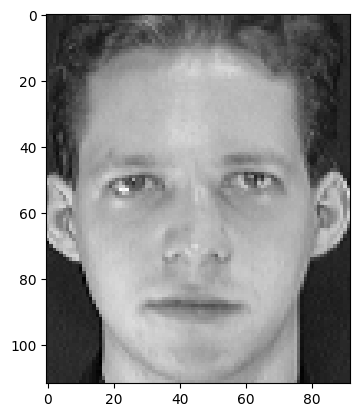

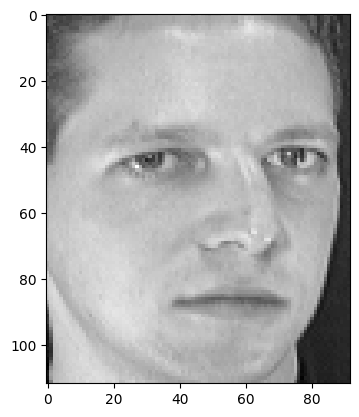

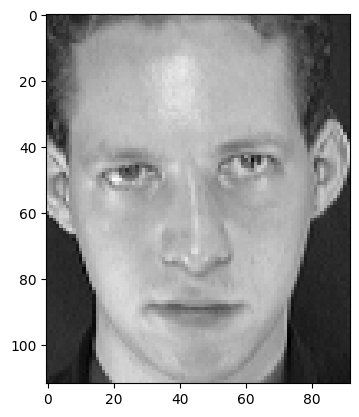

In [130]:
# Test out the function plot_image here by plotting a few of the faces.
for i in range(3):
    plot_image(train_images[i])

Now, before performing principal component analysis, we'll need to make sure that our data set is mean-centered, which you should do here.

In other words, compute the mean vector of the images, and subtract it from each row of our training array (thereby shifting each data point, so that the entire array has mean zero).  Also, plot the mean vector to get an idea of what the average face in our data set looks like.

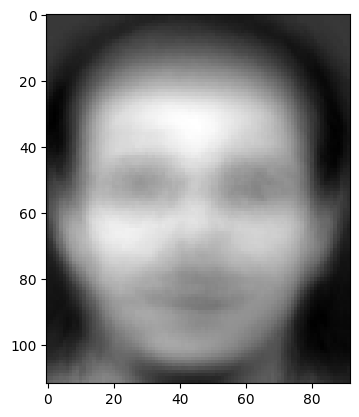

In [131]:
# Center the data points in train_images around their mean.
mean_image = train_images.mean(axis=0)
train_images = train_images - mean_image

# Try plotting the average face, to see what it looks like.
plot_image(mean_image)

The next step in performing PCA will be to compute the covariance matrix, and then find the eigenvalues and eigenvectors of it.  The eigenvalues and eigenvectors of your covariance matrix *cov* can be found using

```
np.linalg.eig(cov)
```

However, as I was playing around with this I found that this was very slow, and that for smaller eigenvalues the eigenvectors didn't seem to be very accurate (I checked this by testing to see if they were orthogonal, and they weren't very close). So there evidentally may be some numerical convergence issues with this algorithm when the eigenvalues are small.

Instead, it's much faster and seemingly more accurate to use *np.linalg.svd* instead, which computes a *singular value decomposition* of a matrix.  

This function computes the (unnormalized) covariance matrix for you, so all you have to do is plug in the matrix with the mean-centered data points as the rows.  For example, suppose that the matrix *X* has rows the mean-centered images.  Then we can compute

```
U,S,Vt = np.linalg.svd(X)
```
Here, the *rows* of *Vt* are the eigenvectors of the unnormalized covariance matrix $X^TX$, while the values in *S* are the square roots of the corresponding eigenvalues (also called the *singular values* of $X$).  

In [132]:
# Compute a singular value decomposition of your mean-centered data matrix.
U, S, Vt = np.linalg.svd(train_images)

Now, plot the first few of the eigenvectors that you obtained above (i.e. the first few rows of $Vt$).  These are called *eigenfaces*.

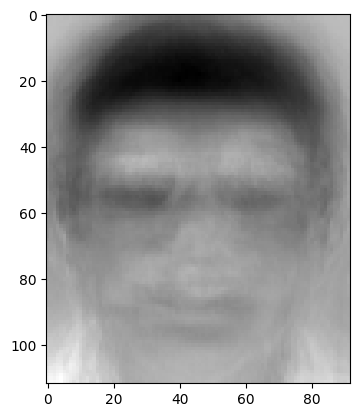

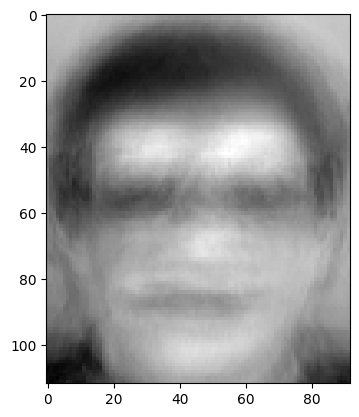

In [133]:
# Plot a couple of eigenfaces here.  They are spooky.
for i in range(2):
    plot_image(Vt[i])

Now plot the singular values of your data matrix to get an idea for how large they are.  From this plot, decide a cut-off value $k$ that seems reasonable (i.e. that captures the largest of the singular values).  This cutoff value will determine the dimension of the subspace onto which you project your data.  


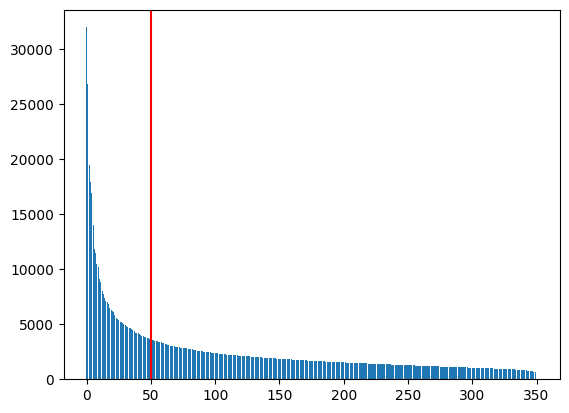

In [134]:
# Plot the singular values, and determine a cutoff point k.
plt.bar(range(len(S)), S)

k = 50
plt.axvline(x=k, color='red')

plt.show()

Then, project each of the vectors in our training dataset onto the subspace spanned by the first $k$ of the eigenvectors in *Vt*.  Project it in such a way that the projection vector has the same dimension as the original vector, so that you can plot the projection vectors.  This can be done using matrix multiplication only (i.e. you shouldn't need to use a for loop). Since our dataset has been mean-centered, don't forget to add the average vector back onto the projected vectors before plotting them.

When you plot a few of the images in the projection vectors, do they resemble the corresponding original images before projection?  If not, try increasing the value of $k$ to see if you can improve the quality of the projection vectors.

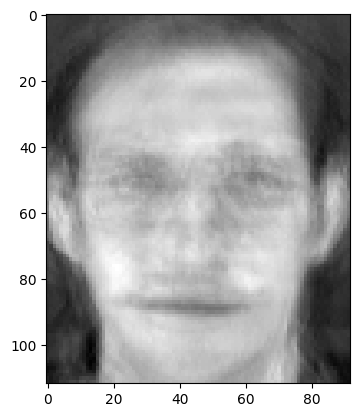

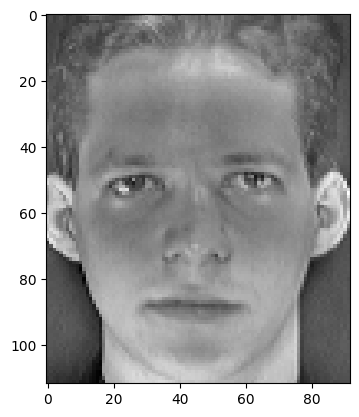

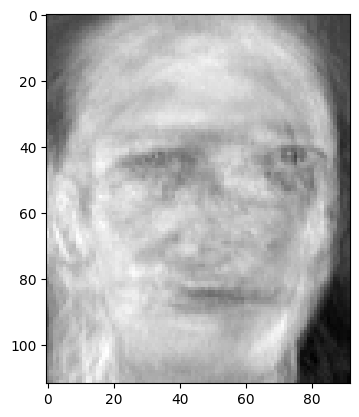

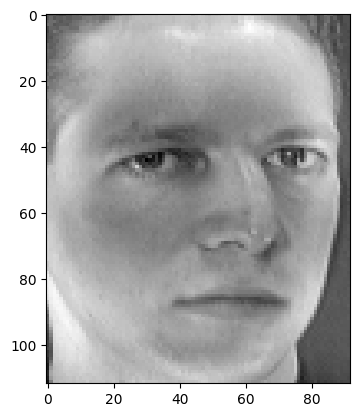

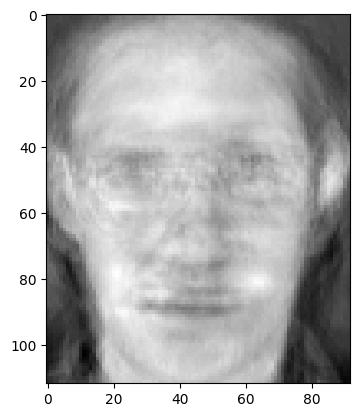

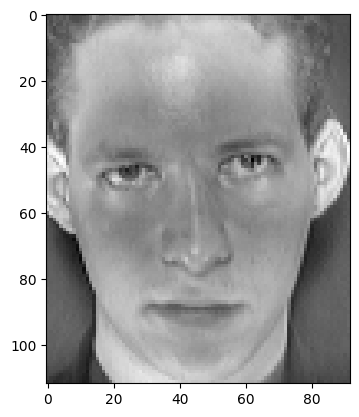

In [135]:
# Project the images onto the k-dimensional subspace you selected.
proj_images = train_images @ Vt[:k].T @ Vt[:k] + mean_image

# Display a few of the projected vector images, and compare them to the corresponding original images.
for i in range(3):
    plot_image(proj_images[i])
    plot_image(train_images[i])
    
# Do they look similar?  If not, try increasing the value of k.

Now remember, we actually want to reduce the dimension of the representation of our data, which the above projection doesn't do.

Project the data again, this time so that each vector is represented as a $k$ dimensional vector (and not merely a 10304-dimensional vector which happens to lie in a $k$-dimensional subspace).  Remember this can be done in the same way as before, only that in this case we use one less matrix multiplication.  Note that after projecting in this way we can no longer plot the resulting images using the *plot_images()* function.

In [136]:
# Project the training data set onto a k-dimensional subspace (this time obtaining k-dimensional coordinate vectors).
proj_images_2 = train_images @ Vt[:k].T

At this point, we are ready to try some facial recognition.

The vectors in the test_images were not involved in computing the eigenvectors, and so we'd like to see how well we can compare these images to the images in our *train_images* dataset.

Begin by mean-centering the test data points using the same average vector that we used when mean-centering the training data.

Then, project the test images to the same $k$-dimesional representation that you used when projecting the training data above.  After projecting, each test image should be a $k$-dimensional vector.

In [137]:
# Mean center the test images, and then project them down to a k-dimensional representation.
mean_test_image = test_images.mean(axis=0)
test_images = test_images - mean_test_image
test_proj_images = test_images @ Vt[:k].T

Now, for each of the test images, we want to compare their projection vector to the set of projection vectors from the training images.  

To do this, take a test image projection vector, and compute the distance of this vector from each of the training image projection vectors.  

To guess the correct label for our test image, find the training image whose projection vector is the closest to the test image projection vector.  Check the label of this closest training image projection vector in the *train_labels* array, and use that label as your guess for the test image.  Then, check the *test_labels* to see if your guess was correct.

Note: Our training set does not contain any images labeled 's40', so you shouldn't be able to correctly predict any of the test images with that label.  However, it might be interesting to see which images in our training set are closest to each of the 's40' images.  Do these images look similar (even though they are of different people)?

Hint: To compare the distance between vectors, you might find the function *np.linalg.norm* useful.

In [ ]:
# Compare the distances of each of the projected test vectors to the projected training vectors.

predicted_labels = [{'index': idx, 'prediction': '', 'actual': ''} for idx in range(len(test_images))]

for test_idx in range(len(test_images)):
    test_vector = test_proj_images[test_idx]

    distances = np.linalg.norm(proj_images_2 - test_vector, axis=1)
    
    # For each test image projection, select the training image whose projection is the closest.    
    predicted_index = np.argmin(distances)

    predicted_label = train_labels[predicted_index]
    actual_label = test_labels[test_idx]

    predicted_labels[test_idx]['prediction'] = str(predicted_label)
    predicted_labels[test_idx]['actual'] = str(actual_label)

# Analysis
(
    pl.DataFrame(predicted_labels)
    .filter(pl.col('actual').ne('s40'))
    .with_columns(
        pl.col('prediction').eq(pl.col('actual')).alias('correct')
    )
    .select(
        pl.col('correct').value_counts()
    )
    .unnest('correct')
)

# Compare the labels of these two vectors.  Do they match?
# How many test images are you able to correctly label (ignoring the 's40' test images).

# We were able to predict 36 of the 39 non 's40' images correctly!

correct,count
bool,u32
false,3
true,36


Now, try running the same experiment with different values of $k$ (i.e. projecting onto subspaces of different dimensions).  How does the value of $k$ affect how accurate your predictions are?

In [139]:
# Run the above experiments again, this time changing the number k of projection dimensions.

new_k = 1

proj_images_3 = train_images @ Vt[:new_k].T
test_proj_images_2 = test_images @ Vt[:new_k].T

predicted_labels = [{'index': idx, 'prediction': '', 'actual': ''} for idx in range(len(test_images))]

for test_idx in range(len(test_images)):
    test_vector = test_proj_images_2[test_idx]

    distances = np.linalg.norm(proj_images_3 - test_vector, axis=1)
    
    # For each test image projection, select the training image whose projection is the closest.    
    predicted_index = np.argmin(distances)

    predicted_label = train_labels[predicted_index]
    actual_label = test_labels[test_idx]

    predicted_labels[test_idx]['prediction'] = str(predicted_label)
    predicted_labels[test_idx]['actual'] = str(actual_label)

# Analysis
(
    pl.DataFrame(predicted_labels)
    .filter(pl.col('actual').ne('s40'))
    .with_columns(
        pl.col('prediction').eq(pl.col('actual')).alias('correct')
    )
    .select(
        pl.col('correct').value_counts()
    )
    .unnest('correct')
)

# How does changing k affect the accuracy of your predictions?
# When we reduce k to 1 (just the first eigen vector), we now only predict 3 images of the 39 no 's40' images correctly.

correct,count
bool,u32
true,3
false,36


The question of how to choose $k$, or in other words, how many *principal components* to include comes down to deciding how much of the variance we need to preserve in our projected data set.  The smaller the value of $k$ (i.e. the fewer *principal components* we use) the more variance we lose when projecting our dataset.  There are lots of articles and tutorials online providing techniques for how to select $k$.

Finally, we should add that all of the work you completed above can be shortcutted, using the PCA function in sklearn.  You can read more about this function [here](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), and try using it to perform the same facial recognition task we performed above.